In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
d1=pd.read_csv('train1.csv')
d1.head()

,text,label
0,The Face on Mars is nothing but a natural occu...,0
1,Students have a higher chance of catching a vi...,0
2,Driverless cars have good and bad things that ...,0
3,Some people might think that traveling in a gr...,1
4,How many of us students want to be forced to d...,0


In [3]:
d1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86587 entries, 0 to 86586
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    86587 non-null  object
 1   label   86587 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [4]:
d1['label'].value_counts()

0    55845
1    30742
Name: label, dtype: int64

In [5]:
d2=pd.read_csv("falcon_180b_v1.csv")
d2.head()

,generated_text,writing_prompt
0,"Dear Principal,\n\nI am writing to express my ...",Your principal is considering changing school ...
1,When people are faced with a difficult decisio...,"When people ask for advice, they sometimes tal..."
2,"As a grade 12 student, I believe that summer p...",Some schools require students to complete summ...
3,"Dear Principal,\n\nI am writing to share my th...",Some of your friends perform community service...
4,"""Making Mona Lisa Smile"" is an interesting art...","In the article ""Making Mona Lisa Smile,"" the a..."


In [6]:
d3=pd.read_csv("llama_70b_v1.csv")
d3.head()

,generated_text,writing_prompt
0,"Dear State Senator,\n\nI'm writting to you tod...",Write a letter to your state senator in which ...
1,"Uh, hi! So, like, summers are, like, awesome r...",Some schools require students to complete summ...
2,"When peoples ask for advices, they sometimes t...","When people ask for advice, they sometimes tal..."
3,I think art edukation is super impotent for ki...,Many people believe that arts education is ess...
4,I think we should totally switch to renewable ...,"In recent years, there has been a push towards..."


In [7]:
data = pd.concat([d2,d3],axis=0,ignore_index=True)
data['label'] = 1
data.columns = ['text','writing_prompt','label']
data = data[['text','label']]
data.head()

,text,label
0,"Dear Principal,\n\nI am writing to express my ...",1
1,When people are faced with a difficult decisio...,1
2,"As a grade 12 student, I believe that summer p...",1
3,"Dear Principal,\n\nI am writing to share my th...",1
4,"""Making Mona Lisa Smile"" is an interesting art...",1


In [8]:
Train_Data = pd.concat([d1,data],axis=0,ignore_index=True)
Train_Data.head()

,text,label
0,The Face on Mars is nothing but a natural occu...,0
1,Students have a higher chance of catching a vi...,0
2,Driverless cars have good and bad things that ...,0
3,Some people might think that traveling in a gr...,1
4,How many of us students want to be forced to d...,0


In [9]:
Train_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88814 entries, 0 to 88813
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    88814 non-null  object
 1   label   88814 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


In [10]:
Train_Data.drop_duplicates(inplace=True,ignore_index=True)

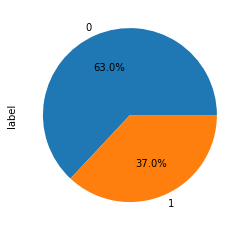

In [11]:
Train_Data['label'].value_counts().plot(kind="pie",autopct="%.1f%%")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

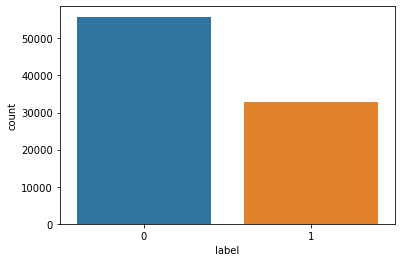

In [12]:
sns.countplot(x=Train_Data['label'])
plt.show

In [13]:
Train_Data['label'].value_counts()

0    55845
1    32772
Name: label, dtype: int64

In [14]:
target=Train_Data['label'].value_counts().min()
majority_class=Train_Data[Train_Data['label']==0]
majority_class_sampled = majority_class.sample(target, random_state=42)

In [15]:
minority_class=Train_Data[Train_Data['label']==1]
Train_Data=pd.concat([majority_class_sampled, minority_class])
Train_Data['label'].value_counts()

0    32772
1    32772
Name: label, dtype: int64

In [16]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [17]:
X_train, X_test, y_train, y_test = train_test_split(Train_Data['text'], Train_Data['label'], test_size=0.1, random_state=42)

In [18]:
import re
def normalize(text):
    text = text.replace("\n", " ").replace("\r", " ")
    text = re.sub(r'[^\w\s]', ' ', text)     #remove special characters
    text = re.sub(r'\s+', ' ', text)    #replace multiple spaces with single space
    return text.strip()

X_train = X_train.apply(normalize)
X_test = X_test.apply(normalize)

In [19]:
# Vectorize the text data
def custom_tokenizer(text):
    return re.findall(r'\b\w+\b', text)


vectorizer = TfidfVectorizer(
    ngram_range=(3, 4),
    tokenizer=custom_tokenizer,
    token_pattern=None,
    strip_accents='unicode'
)

vectorizer.fit(X_train)

X_train_vectorized = vectorizer.transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)


import pickle
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [20]:
logistic_model = LogisticRegression(C=0.01)
naive_bayes_model = MultinomialNB(alpha=1.0)

ensemble = VotingClassifier(
    estimators=[
        ('logistic', logistic_model),
        ('naive_bayes', naive_bayes_model)
    ],
    weights=[0.35, 0.65],
    voting='soft'
)

ensemble.fit(X_train_vectorized, y_train)

VotingClassifier(estimators=[('logistic', LogisticRegression(C=0.01)),
                             ('naive_bayes', MultinomialNB())],
                 voting='soft', weights=[0.35, 0.65])

In [21]:
with open('ensemble_model.pkl', 'wb') as f:
    pickle.dump(ensemble, f)

In [22]:
from sklearn.metrics import accuracy_score
y_pred = ensemble.predict(X_test_vectorized)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9986270022883296


In [24]:
texti="To address the overfitting issue while maintaining a high-performance model, you can adjust the hyperparameters of the LogisticRegression and MultinomialNB models more significantly. Here’s a more cautious approach"
texti=normalize(texti)
texti=vectorizer.transform([texti])
print(ensemble.predict_proba(texti))

[[0.4150533 0.5849467]]
